In [1]:
import pandas as pd
import os,shutil,math
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.utils import shuffle
from keras.optimizers import Adam,SGD
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten , Dropout , GlobalAveragePooling2D

In [2]:
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')


In [3]:
SAMPLE_SIZE= 80000
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [4]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [5]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [6]:
os.listdir('base_dir/train_dir')

['b_has_tumor_tissue', 'a_no_tumor_tissue']

In [7]:
df_data.set_index('id', inplace=True)

In [8]:

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    


   


In [9]:
#------Generators------------#
train_augs = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    channel_shift_range=0.1
)


val_augs = ImageDataGenerator(rescale=1./255)

train_gen = train_augs.flow_from_directory(
    "./base_dir/train_dir",
    target_size=(96,96),
    batch_size=10,
    class_mode='binary')

val_gen = val_augs.flow_from_directory(
    "./base_dir/val_dir",
    target_size=(96,96),
    batch_size=10,
    class_mode='binary')
#print(train_gen.class_indices)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [10]:
c = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1, 
    mode='auto',
    cooldown=1 
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)
callbacks=[c,earlystop,tensorboard]

In [11]:
base_model = VGG19(include_top=False,
                  input_shape = (96,96,3),
                  weights = 'imagenet')

for layer in base_model.layers[:-15]:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input,outputs=predictions)
model.summary()
opt = SGD(lr=1e-4,momentum=0.99)
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_______________________________________________________

In [12]:
history = model.fit_generator(
    train_gen,  
    steps_per_epoch  = 2000, 
    validation_data  = val_gen,
    epochs = 30, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/30
2000/2000 [==============================] - 119s 59ms/step - loss: 0.4790 - accuracy: 0.7770 - val_loss: 0.3651 - val_accuracy: 0.8366
Epoch 2/30
2000/2000 [==============================] - 117s 59ms/step - loss: 0.3868 - accuracy: 0.8278 - val_loss: 0.3095 - val_accuracy: 0.8644
Epoch 3/30
2000/2000 [==============================] - 115s 58ms/step - loss: 0.3502 - accuracy: 0.8449 - val_loss: 0.3439 - val_accuracy: 0.8563
Epoch 4/30
2000/2000 [==============================] - 116s 58ms/step - loss: 0.3310 - accuracy: 0.8577 - val_loss: 0.2628 - val_accuracy: 0.8947
Epoch 5/30
2000/2000 [==============================] - 114s 57ms/step - loss: 0.3211 - accuracy: 0.8630 - val_loss: 0.2851 - val_accuracy: 0.8829
Epoch 6/30
2000/2000 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.8749
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
2000/2000 [==============================] - 113s 56ms/step - loss: 0.2997 - accuracy:

In [25]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

Validation Accuracy: [0.9178125262260437]


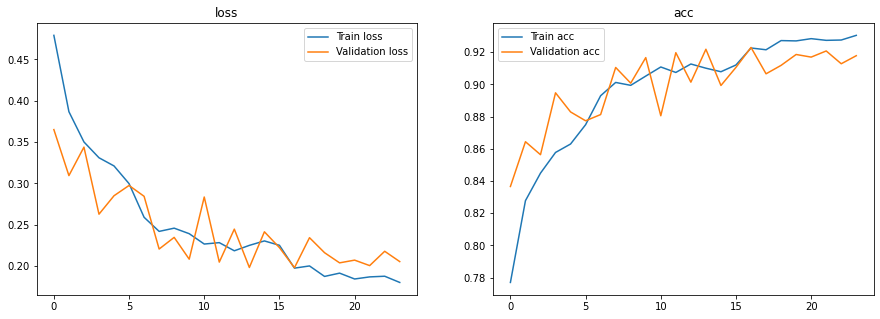

In [26]:
show_final_history(history)
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

In [47]:
shutil.rmtree('base_dir')
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
os.listdir('test_dir')

['test_images']

In [49]:
test_list = os.listdir('../input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [50]:
len(os.listdir('test_dir/test_images'))


57458

In [52]:
test_path ='test_dir'
datagen = ImageDataGenerator(rescale=1.0/255)


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(96,96),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [53]:
num_test_images = 57458

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

57458/57458 [==============================] - 284s 5ms/step


In [54]:
len(predictions)

57458

In [56]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=["tumor"])

df_preds.head()


,tumor
0,0.999480
1,0.966515
2,0.955664
3,0.997447
4,0.002742


In [57]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,tumor,file_names
0,0.999480,test_images/00006537328c33e284c973d7b39d340809...
1,0.966515,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.955664,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.997447,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.002742,test_images/000270442cc15af719583a8172c87cd2bd...


In [58]:
def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,tumor,file_names,id
0,0.999480,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.966515,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.955664,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.997447,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.002742,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [59]:
submission = pd.DataFrame({'id':df_preds.id, 
                           'label':df_preds.tumor, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 

In [61]:
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.999480
0000ec92553fda4ce39889f9226ace43cae3364e,0.966515
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.955664
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.997447
000270442cc15af719583a8172c87cd2bd9c7746,0.002742


In [ ]:
shutil.rmtree('test_dir')